<a href="https://colab.research.google.com/github/thai94/d2l/blob/main/4.multilayer_perceptrons/4_4_model_selection_underfitting_and_overfitting_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [154]:
import math
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils import data as data

In [155]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))

poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
  poly_features[:, i] /= math.gamma(i + 1)

labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [156]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

In [157]:
poly_features.shape

torch.Size([200, 20])

In [158]:
poly_features[0]

tensor([1.0000e+00, 3.7216e-01, 6.9252e-02, 8.5910e-03, 7.9931e-04, 5.9495e-05,
        3.6903e-06, 1.9620e-07, 9.1272e-09, 3.7742e-10, 1.4046e-11, 4.7522e-13,
        1.4738e-14, 4.2193e-16, 1.1216e-17, 2.7828e-19, 6.4728e-21, 1.4170e-22,
        2.9298e-24, 5.7387e-26])

In [159]:
labels.shape

torch.Size([200])

In [160]:
class Accumulator:
  def __init__(self, n):
    self.data = [0.0] * n
  
  def add(self, *args):
    self.data = [a + float(b) for a,b in zip(self.data, args)]

  def reset(self):
    self.data = [0.0] * len(self.data)
    
  def __getitem__(self, idx):
    return self.data[idx]

In [161]:
def evaluate_loss(net, data_iter, loss):
  metric = Accumulator(2)
  for X, y in data_iter:
    out = net(X)
    y = y.reshape(out.shape)
    l = loss(out, y)
    metric.add(l.sum(), l.numel())
  return metric[0] / metric[1]

In [162]:
def load_array(data_arrays, batch_size, is_train=True):
  dataset = data.TensorDataset(*data_arrays)
  return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [163]:
def train_epoch_ch3(net, train_iter, loss, updater):
  for X, y in train_iter:
    y_hat = net(X)
    l = loss(y_hat, y)
    if isinstance(updater, torch.optim.Optimizer):
      updater.zero_grad()
      l.sum().backward()
      updater.step()
    else:  
      l.sum().backward()
      updater(X.shape[0])

In [164]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):

  loss = nn.MSELoss(reduction='none')
  input_shape = train_features.shape[-1]
  net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
  batch_size = min(10, train_labels.shape[0])
  train_iter = load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
  test_iter = load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
  trainer = torch.optim.SGD(net.parameters(), lr=0.01)

  x = []
  train_loss = []
  test_loss = []
  for epoch in range(num_epochs):
    train_epoch_ch3(net, train_iter, loss, trainer)
    if epoch == 0 or (epoch + 1) % 20 == 0:
      x.append(epoch)
      train_loss.append(evaluate_loss(net, train_iter, loss))
      test_loss.append(evaluate_loss(net, test_iter, loss))

  plt.plot(x, train_loss, 'r')
  plt.plot(x, test_loss, 'b')
  plt.show()

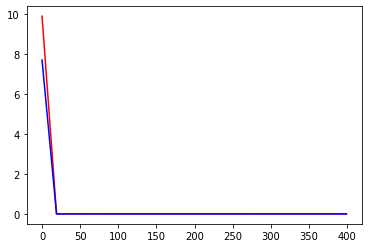

In [167]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

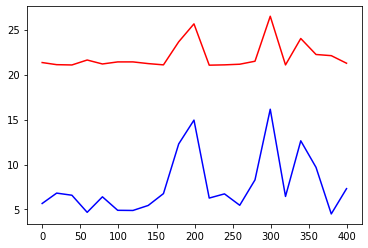

In [168]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

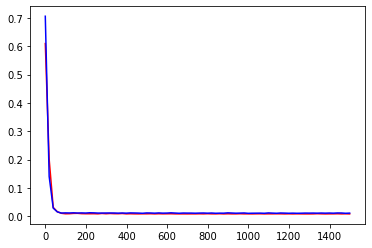

In [166]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)